In [3]:
import numpy as np
rng = np.random.default_rng()
import matplotlib.pyplot as plt
import matplotlib
%matplotlib widget
cmap = matplotlib.colormaps.get('tab10').colors
import gen_graph as gg

In [4]:
# LEGACY

# def hexagon_correction(nodes, connections, size):
#     removed_node_indices = []
#     skip_index = -1
#     for i in range(size[0]):
#         # Go through the rows
#         skip_index +=1
#         for j in range(size[1]):
#             # Go through the nodes in the row and remove every third, starting from a different index
#             if (j-skip_index)%3 == 0:
#                 removed_node_indices.append(i*size[1]+j)    
#     nodes = np.delete(nodes, removed_node_indices, axis=0)
#     connections = [edge for edge in connections if edge[0] not in removed_node_indices and edge[1] not in removed_node_indices]
#     connections = np.array(connections)
#     print(removed_node_indices)
#     for i in removed_node_indices:
#         connections[i-1:] -= 1
        
#     return nodes, connections
    

In [5]:
def plot_graph(nodes, connections):
    '''
    Function that plots the graph. It takes the following arguments:
    - nodes (arr): The array of nodes
    - connections (arr): The array of connections
    '''
    _,ax = plt.subplots()
    ax.plot(nodes[:,0], nodes[:,1], 'ro')
    for edge in connections.T:
        ax.plot([nodes[edge[0]][0], nodes[edge[1]][0]], [nodes[edge[0]][1], nodes[edge[1]][1]], 'g-')
    ax.set_aspect('equal')

In [4]:
import torch
import torch_geometric as tg
import random
def load_data(paths):
    dataset = []
    for path in paths:
        graphs = np.load(path)
        dataset.extend([tg.data.Data(
                        x=torch.tensor(graphs['attr'][i], dtype=torch.float),
                        edge_index=torch.tensor(graphs['edges'][i], dtype=torch.int),
                        edge_attr=torch.tensor(graphs['edge_attr'][i], dtype=torch.float),
                        y=torch.tensor(graphs['y'][i], dtype=torch.float),
                        pos=torch.tensor(graphs['coords'][i], dtype=torch.float)  
                         ) for i in range(len(graphs['attr']))])
        print(len(dataset))
        random.shuffle(dataset)
    trainable_graphs = int(0.2 * len(dataset))
    train_loader = tg.loader.DataLoader(dataset[:trainable_graphs], batch_size=5, shuffle=True)
    test_loader = tg.loader.DataLoader(dataset[trainable_graphs:], batch_size=5, shuffle=True)
    return train_loader, test_loader
train_loader, test_loader = load_data(['graphs/hex.npz', 'graphs/rect.npz', 'graphs/sq.npz'])

100
200
300


In [9]:
def plot_graph_tg(data: tg.data.Data):
    '''
    Function that plots the graph. It takes the following arguments:
    - a tg.data.Data object
    '''
    coords = data['pos']
    edges = data['edge_index']
    _,ax = plt.subplots()
    ax.plot(coords[:,0], coords[:,1], 'ro')
    ax.plot((coords[:,0][edges[0]], coords[:,0][edges[1]]), (coords[:,1][edges[0]], coords[:,1][edges[1]]), 'g-')
    
#plot_graph_tg(train_loader.dataset[12])

In [13]:
class GCN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        torch.manual_seed(12345)
        self.conv1 = tg.nn.GCNConv(1, 4)
        self.conv2 = tg.nn.GCNConv(4,8)
        self.classifier = torch.nn.Linear(8, 3)
    def forward(self, x, edge_index, batch):
        x = torch.tanh(self.conv1(x, edge_index))
        x = self.conv2(x, edge_index)
        
        x = tg.nn.global_mean_pool(x, batch)
        out = torch.nn.functional.softmax(self.classifier(x), dim=1)
        
        return out
model = GCN()
print(model)

GCN(
  (conv1): GCNConv(1, 4)
  (conv2): GCNConv(4, 8)
  (classifier): Linear(in_features=8, out_features=3, bias=True)
)


In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = torch.nn.CrossEntropyLoss()

def train(loader):
    model.train()
    for data in loader:
        out = model(data.x, data.edge_index, data.batch)# Perform a single forward pass.
        loss = criterion(out, data.y)  # Compute the loss.
        #print(loss)
        loss.backward()  # Derive gradients.
        optimizer.step()  # Update parameters based on gradients.
        optimizer.zero_grad() # Reset grads.
def test(loader):
    model.eval()
    correct = 0
    for data in loader:
        out = model(data.x, data.edge_index, data.batch)
        pred = out.argmax(dim=1)  # Use the class with highest probability.
        true = data.y.argmax(dim=1)
        #print(true)
        correct += int((true == pred).sum())
    return correct / len(loader.dataset)

In [15]:
for epoch in range(1, 100):
    train(train_loader)
    acc = test(train_loader)
    if epoch % 1 == 0:
        print(f'Epoch: {epoch:03d}, Test Accuracy: {acc:.5f}')

Epoch: 001, Test Accuracy: 0.40000
Epoch: 002, Test Accuracy: 0.40000
Epoch: 003, Test Accuracy: 0.40000
Epoch: 004, Test Accuracy: 0.40000
Epoch: 005, Test Accuracy: 0.40000
Epoch: 006, Test Accuracy: 0.71667
Epoch: 007, Test Accuracy: 0.71667
Epoch: 008, Test Accuracy: 0.71667
Epoch: 009, Test Accuracy: 0.71667
Epoch: 010, Test Accuracy: 0.71667
Epoch: 011, Test Accuracy: 0.71667
Epoch: 012, Test Accuracy: 0.71667
Epoch: 013, Test Accuracy: 0.71667
Epoch: 014, Test Accuracy: 0.71667
Epoch: 015, Test Accuracy: 0.71667
Epoch: 016, Test Accuracy: 0.71667
Epoch: 017, Test Accuracy: 0.71667
Epoch: 018, Test Accuracy: 0.71667
Epoch: 019, Test Accuracy: 0.71667
Epoch: 020, Test Accuracy: 0.71667
Epoch: 021, Test Accuracy: 0.71667
Epoch: 022, Test Accuracy: 0.71667
Epoch: 023, Test Accuracy: 0.71667
Epoch: 024, Test Accuracy: 0.71667
Epoch: 025, Test Accuracy: 0.71667
Epoch: 026, Test Accuracy: 0.71667
Epoch: 027, Test Accuracy: 0.71667
Epoch: 028, Test Accuracy: 0.71667
Epoch: 029, Test Acc

c:\Users\steph\OneDrive\Dokumente\VS Code\Python\Computerpraktikum\gen_dataset.py:55: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(os.path.join(self.proce

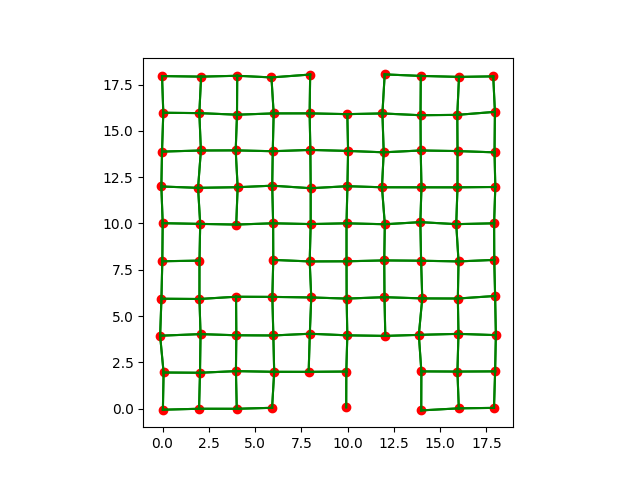

In [6]:
from gen_dataset import PlaneGraphDataset
dataset = PlaneGraphDataset(root='plane_graphs')
graph = dataset[0]
plot_graph(graph.pos, graph.edge_index)